# HM04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cluster import KMeans
import sklearn

from sklearn.preprocessing import StandardScaler

In [2]:
#Load the data
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
list(data.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

## 0. Data Cleaning

### 0.1 NaN Values

In [5]:
def columns_nanValues(data):
    # print all columns with at least one NaN value
    l = list()
    for c in data:
        if data[c].hasnans:
            l.append(c)
    return l

columns_nanValues(data)

['height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

**Remove entries with no Skin Color feature**

Some columns contains NaN values. For this homework, we will not be able to work with data having no *skin color* feature. Therefore we only keep instances with this information.

In [6]:
# We remove all instance with no 'photoID' information, since the skin color needs this information
data_clean = data[~data.photoID.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height',
 'weight',
 'position',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [7]:
data_clean[nan_col].dtypes

height      float64
weight      float64
position     object
Alpha_3      object
meanIAT     float64
nIAT        float64
seIAT       float64
meanExp     float64
nExp        float64
seExp       float64
dtype: object

**Percentage of NaN cells per column**

In [8]:
for x in nan_col:
    nbr = data_clean[x].isnull().sum()
    print(x, '-->', nbr)
    print("   Total percentage: ", nbr/len(data_clean)*100)

height --> 46
   Total percentage:  0.0369119169321
weight --> 753
   Total percentage:  0.60423203152
position --> 8461
   Total percentage:  6.78938541658
Alpha_3 --> 1
   Total percentage:  0.000802432976786
meanIAT --> 153
   Total percentage:  0.122772245448
nIAT --> 153
   Total percentage:  0.122772245448
seIAT --> 153
   Total percentage:  0.122772245448
meanExp --> 153
   Total percentage:  0.122772245448
nExp --> 153
   Total percentage:  0.122772245448
seExp --> 153
   Total percentage:  0.122772245448


For the values related to the *IAT* and *Exp*, we decided to remove those rows, since the fraction of "corrupt" rows is almost insignificant.

In [9]:
data_clean = data_clean[~data_clean.nIAT.isnull()]
# Colums still have NaN values
nan_col = columns_nanValues(data_clean)
nan_col

['height', 'weight', 'position']

### 0.2 Dealing with missing data

**Potential fixes to missing cells**

We know that there are multiple entries per player in our dataset. Therefore, is it possible that the information about *weight*, *height*, or *position* for a player is missing in one entry but present in another ? If yes, we could simply replace the missing values by the ones present in another row, but as we can see, such case doesn't occur.

In [10]:
# Assert if any missing values for a player feature
# are not present in another row

for col in nan_col:
    data_noWeight = data_clean[data_clean[col].isnull()]
    data_withWeight = data_clean[~data_clean[col].isnull()]

    i1 = list(data_noWeight.index)
    i2 = list(data_withWeight.index)

    nbr = [x for x in i1 if x in i2]
    print(col, '-->', nbr)

height --> []
weight --> []
position --> []


**Drop rows or fill mean values to the cell**

Now we are sure that there is no way to recover this values. We have therefore two possibilities:
- Replace the missing *height* and *weight* values by the mean of all players
- Remove the rows with missing values

We've decided to go for the second option, as the percentage of data concern is low (then that 1%)

In [11]:
nan_values_to_drop = ['weight', 'height']
for col in nan_values_to_drop:
    data_clean = data_clean[~data_clean[col].isnull()]

In [12]:
# Last feature to clean
columns_nanValues(data_clean)

['position']

There is still one remaining feature for which we need to clean. For the *position* column, we can:

- Replace all missing entries by a *dummy* variable, like "Unknown"
- Replace all missing entries by the most frequent one according to the rest entries (*position* is not numerical, therefore no mean)
- Remove the rows with missing values

We decide to remove those rows. But before doing so, we want to assert that we aren't throwing valuable information. We compare the skin color rated by *rater1* and *rater2* column with NaN value against the data witouh NaN values.

In [13]:
# Data WITH NaNs values
nan_data = data_clean[data_clean.position.isnull()]
print(nan_data.rater1.describe())
print('----')
print(nan_data.rater2.describe())

count    8258.000000
mean        0.287600
std         0.297938
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater1, dtype: float64
----
count    8258.000000
mean        0.324837
std         0.313449
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater2, dtype: float64


In [14]:
# Data WITHOUT NaNs values
good_data = data_clean[~data_clean.position.isnull()]
print(good_data.rater1.describe())
print('----')
print(good_data.rater2.describe())

count    115457.000000
mean          0.261946
std           0.294666
min           0.000000
25%           0.000000
50%           0.250000
75%           0.250000
max           1.000000
Name: rater1, dtype: float64
----
count    115457.000000
mean          0.300796
std           0.291061
min           0.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: rater2, dtype: float64


**Remove rows with empty position information based on observation of skin color rating comparison**

As we cann see, there is no major difference between the two portions of data. Therefore, we have decided to remove these rows.


| rater1| NaN | No NaN |
|------|--------|--------|
| mean |    0.287600    |    0.261946    |
| std  |     0.297938   |  0.294666      |


| rater2| NaN | No NaN |
|------|--------|--------|
| mean |    0.324837    |    0.300796    |
| std  |     0.313449   |  0.291061      |

In [15]:
# Remove all entries with NaNs values in the 'position' column
data_clean = data_clean[~data_clean.position.isnull()]

In [16]:
# Assert no more "NaN" values in our dataframe
columns_nanValues(data_clean)

[]

### 0.3 Tuning the SkinColor feature

The *skin color* feature is stored in two columns: *rater1* and *rater2*. Based on these two columns, we create a new feature *skinColor* by aggregating the two results. But before, let's take a look on the raters results.

In [17]:
data_skin = data_clean
data_skin["skinColorDiff"] = (data_skin.rater1-data_skin.rater2).abs()

It's obvious that the two raters aren't always on the same page, therefore it is natural to have different results for the same player.

In [18]:
# Search if there are entries where rater rating differ more than 0.25
data_colorDiff = data_skin[data_skin.skinColorDiff > 0.25]
len(data_colorDiff)

164

For 164 entries, the two raters have major split opinions.

In [19]:
print(data_colorDiff.rater1.unique())
print(data_colorDiff.rater2.unique())

[ 0.]
[ 0.5]


**Keep entries with consistent skin ratings**

**Reason:** When one rater consider the player's skin as *very light skin* and the other as *neither dark not light skin*. The number of these entries are small comparing to the entire dataset and any attemp to make a compromise of the two and leaving these entries in might raise the bias of the outcome of our classifier, we've decided that those entries aren't reliable and therefore remove it.

In [20]:
## Display the total number of entries
data_skin_clean = data_skin[data_skin.skinColorDiff <= 0.25]
len(data_skin_clean)

115293

**Merge two columns in one**

Now we can create the *skinColor* feature by aggregating the two raters results.

In [21]:
# Add the skin color based on the two raters
data_skin_clean["skinColor"] = (data_skin.rater1+data_skin.rater2)/2

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 0.4 Remove referees

Now we need to look a little more into the referees features. As mentionned in the [complementary reading](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) for this assignement, there are some referees in this dataset who have less than 22 dyads. Since we want to take into consideration only games in the four leagues (England, France, Germany, and Spain), we need to remove all dyads where a referee has less that 22 games. Note that these doesn't mean we remove all possible ref-related noise of our data.

In [22]:
# Group the data by refs
data_by_refs = data_skin_clean.groupby('refNum').size()
refsToKeep = data_by_refs >= 22

# Retrieve the 'refNum' of refs to keep in the data
refsToKeepID = list()
for i,x in enumerate(refsToKeep):
    if x:
        refsToKeepID.append(refsToKeep.index[i])

# Keep only the refs with at least 22 games
data_clean = data_skin_clean[data_skin_clean.refNum.isin(refsToKeepID)]

In [23]:
data = data_clean
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.000


Now, we consider that our dataset is clean and we can go for the first part of the assignment!

> Note about the data. We found something disturbing. The player *Aaron Hughes* has played, according to wikipedia, 

## 1.
>Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

### 1.1 Cross-Featuring
For this first part, we only care about player description. Therefore, we need to keep only one entry per player and for each player to aggregate his data with all refs with who he has a dyad.

In [24]:
data_by_player = data.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'player'    : 'first',
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum all referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
        
        'meanIAT'   : 'mean',
        'meanExp'   : 'mean',
        'seIAT'     : 'mean',
        'seExp'     : 'mean'
    })

data_player.head()

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,victories,position,games,player,leagueCountry,yellowReds,weight,birthday,defeats,skinColor
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,174,0.001321,0,Fulham FC,182.0,0.345065,0.484931,0.000282,19,8,240,Center Back,635,Aaron Hughes,England,0,71.0,08.11.1979,221,0.125
aaron-hunt,70,0.001032,1,Werder Bremen,183.0,0.349424,0.451448,0.000227,39,59,139,Attacking Midfielder,328,Aaron Hunt,Germany,0,73.0,04.09.1986,119,0.125
aaron-lennon,96,0.002052,0,Tottenham Hotspur,165.0,0.346085,0.492832,0.000371,11,31,200,Right Midfielder,411,Aaron Lennon,England,0,63.0,16.04.1987,115,0.250
aaron-ramsey,42,0.002826,1,Arsenal FC,178.0,0.347013,0.511374,0.000496,31,39,144,Center Midfielder,253,Aaron Ramsey,England,0,76.0,26.12.1990,67,0.000
abdelhamid-el-kaoutari,40,0.005296,2,Montpellier HSC,180.0,0.331600,0.335587,0.001488,8,1,41,Center Back,124,Abdelhamid El-Kaoutari,France,4,73.0,17.03.1990,43,0.250


In [72]:
data_player.sort(columns="games", ascending=False)["games"]

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


playerShort
frank-lampard             890.0
xavi                      789.0
iker-casillas             773.0
steven-gerrard            763.0
jamie-carragher           745.0
john-arne-riise           703.0
rio-ferdinand             700.0
john-terry                695.0
mark-schwarzer            677.0
paul-scholes              674.0
xabi-alonso               665.0
gareth-barry              665.0
phil-neville              661.0
ashley-cole               660.0
petr-cech                 655.0
mickael-landreau          654.0
shay-given                646.0
cristiano-ronaldo         645.0
pepe-reina                639.0
puyol                     638.0
aaron-hughes              635.0
william-gallas            612.0
wayne-rooney              607.0
michael-carrick           602.0
bastian-schweinsteiger    601.0
philipp-lahm              600.0
florent-malouda           594.0
fernando-torres           593.0
claudio-pizarro           589.0
john-oshea                584.0
                          ..

#### 1.1.1 IAT and Exp
There is still some columns that we can aggregate from the original dataset. We decided to combine the *meanIAT* and *meanExp* together, and the *seIAT* with the *seExp*.

In [26]:
# Before aggregations the IAT and Exp data together, we decided to change the data
# in order to have values between [0,1]

def column_maxmin(column):
    """
        Normalize the column values in a given dataframe
    """
    maxmin = column.max() - column.min()
    return (column - column.min()) / maxmin


data_player.meanIAT = column_maxmin(data_player.meanIAT)
data_player.seIAT   = column_maxmin(data_player.seIAT)
data_player.meanExp = column_maxmin(data_player.meanExp)
data_player.seExp   = column_maxmin(data_player.seExp)

Now we can aggregate the columns.
- $meanIATEXP = \frac{meanIAT + meanExp}{2}$
- $seIATEXP = \sqrt{seIAT² + seExp^2}$

In [27]:
data_player["meanIATEXP"] = (data_player.meanIAT + data_player.meanExp) / 2
data_player["seIATEXP"] = (data_player.seIAT**2 + data_player.seExp**2)**0.5
data_player.head()

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,...,games,player,leagueCountry,yellowReds,weight,birthday,defeats,skinColor,meanIATEXP,seIATEXP
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,174,0.028156,0,Fulham FC,182.0,0.527935,0.434369,0.030137,19,8,...,635,Aaron Hughes,England,0,71.0,08.11.1979,221,0.125,0.481152,0.041243
aaron-hunt,70,0.021812,1,Werder Bremen,183.0,0.567933,0.399713,0.024027,39,59,...,328,Aaron Hunt,Germany,0,73.0,04.09.1986,119,0.125,0.483823,0.032451
aaron-lennon,96,0.044180,0,Tottenham Hotspur,165.0,0.537290,0.442548,0.039880,11,31,...,411,Aaron Lennon,England,0,63.0,16.04.1987,115,0.250,0.489919,0.059518
aaron-ramsey,42,0.061155,1,Arsenal FC,178.0,0.545806,0.461739,0.053753,31,39,...,253,Aaron Ramsey,England,0,76.0,26.12.1990,67,0.000,0.503773,0.081421
abdelhamid-el-kaoutari,40,0.115304,2,Montpellier HSC,180.0,0.404375,0.279791,0.163288,8,1,...,124,Abdelhamid El-Kaoutari,France,4,73.0,17.03.1990,43,0.250,0.342083,0.199895


#### 1.1.2  Cards
Players can receive a yellow card, a red card resulting of two yellows one, or a direct red card. 

We've decided to combine these cards features:
- *cardsPerGame*: Sum of all cards divided by the number of games
- *yellowCardNorm*: The number of yellow cards for a player divided by the total number of yellow cards (for all players). Between [0,1]
- *yellowRedsNorm*: Same as *yellowCardStand*, but with the yellowReds
- *redCardsNorm*: Same as *yellowCardStand*, but with the redCards

In [28]:
# cardsPerGame
data_player['cardsPerGame'] = (data_player.yellowCards + data_player.yellowReds + data_player.redCards)\
                                / data_player.games

In [29]:
#yellowCardNorm
data_player['yellowCardNorm'] = data_player.yellowCards / data_player.yellowCards.sum()
data_player['yellowCardNorm'] = column_maxmin(data_player['yellowCardNorm'])

In [30]:
#yellowRedsNorm
data_player['yellowRedsNorm'] = data_player.yellowReds / data_player.yellowReds.sum()
data_player['yellowRedsNorm'] = column_maxmin(data_player['yellowRedsNorm'])

In [31]:
#redCardsNorm
data_player['redCardsNorm'] = data_player.redCards / data_player.redCards.sum()
data_player['redCardsNorm'] = column_maxmin(data_player['redCardsNorm'])

In [32]:
data_player.head()

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,...,weight,birthday,defeats,skinColor,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,174,0.028156,0,Fulham FC,182.0,0.527935,0.434369,0.030137,19,8,...,71.0,08.11.1979,221,0.125,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000
aaron-hunt,70,0.021812,1,Werder Bremen,183.0,0.567933,0.399713,0.024027,39,59,...,73.0,04.09.1986,119,0.125,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909
aaron-lennon,96,0.044180,0,Tottenham Hotspur,165.0,0.537290,0.442548,0.039880,11,31,...,63.0,16.04.1987,115,0.250,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000
aaron-ramsey,42,0.061155,1,Arsenal FC,178.0,0.545806,0.461739,0.053753,31,39,...,76.0,26.12.1990,67,0.000,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909
abdelhamid-el-kaoutari,40,0.115304,2,Montpellier HSC,180.0,0.404375,0.279791,0.163288,8,1,...,73.0,17.03.1990,43,0.250,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818


#### 1.1.3 Cards & IATEXP

We want to create a feature by combing the cards and the IAT and Exp data. Therefore, we create a new feature:
- *cardsIATExp* = (yellowCardNorm + yellowRedsNorm + redCardsNorm) * meanIATEXP

In [33]:
data_player['cardsIATExp'] = (data_player.yellowCardNorm + data_player.yellowRedsNorm + data_player.redCardsNorm) \
                                * data_player.meanIATEXP
    
data_player.head()

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,...,birthday,defeats,skinColor,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,174,0.028156,0,Fulham FC,182.0,0.527935,0.434369,0.030137,19,8,...,08.11.1979,221,0.125,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000,0.048887
aaron-hunt,70,0.021812,1,Werder Bremen,183.0,0.567933,0.399713,0.024027,39,59,...,04.09.1986,119,0.125,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909,0.144888
aaron-lennon,96,0.044180,0,Tottenham Hotspur,165.0,0.537290,0.442548,0.039880,11,31,...,16.04.1987,115,0.250,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000,0.028819
aaron-ramsey,42,0.061155,1,Arsenal FC,178.0,0.545806,0.461739,0.053753,31,39,...,26.12.1990,67,0.000,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909,0.129311
abdelhamid-el-kaoutari,40,0.115304,2,Montpellier HSC,180.0,0.404375,0.279791,0.163288,8,1,...,17.03.1990,43,0.250,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818,0.190859


### 1.2 Convert columns types

As seen previously, some of our columns have the *object* type. Since the library we are using doesn't deal with this type of column values, we need to change it by using a *LabelEncoder()*

In [34]:
def columnEncoder(df, col):
    """
    Replace all values of a column by applying the 'LabelEncoder' form 'sklearn'
    
    INPUT:
        df: The dataframe containing the columns to change
        col: The column name over which the 'LabelEncoder' will be applied
        
    OUTPUT:
        The dataframe with news values in the specified column
    """
    labelEncoder = preprocessing.LabelEncoder()
    df[col] = labelEncoder.fit_transform(df[col])

In [35]:
data_player.dtypes

ties                int64
seExp             float64
redCards            int64
club               object
height            float64
meanIAT           float64
meanExp           float64
seIAT             float64
yellowCards         int64
goals               int64
victories           int64
position           object
games               int64
player             object
leagueCountry      object
yellowReds          int64
weight            float64
birthday           object
defeats             int64
skinColor         float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

In [36]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now all the columns are numbers, but we have decided to work only *float64* values.

In [37]:
data_player = data_player.astype(float)
data_player.dtypes

ties              float64
seExp             float64
redCards          float64
club              float64
height            float64
meanIAT           float64
meanExp           float64
seIAT             float64
yellowCards       float64
goals             float64
victories         float64
position          float64
games             float64
player            float64
leagueCountry     float64
yellowReds        float64
weight            float64
birthday          float64
defeats           float64
skinColor         float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

### 1.3 Prepare data for ML

In [38]:
X = data_player.drop('skinColor', axis=1)

The assignement asked us to use the *RandomForestClassifier*. Therefore, we need to work with discrete values. We've decided to add a new column to our data: *isBlack*. This column takes the value *True* if the *skinColor* average of the two raters is bigger than 0.5.

Note that if *isBlack* is false, it doesn't mean that the player has light skin (can be *neither dark nor light skin*).

In [39]:
data_player['isBlack'] = data_player["skinColor"] > 0.5
y = data_player['isBlack']

### 1.4 Random Forest Classifier - Assert model

As specified in the assignement, we use *cross-validation* with the *radom forest classifier* to perform our prediction, therefore mitigating the overfitting of the model.

We start by choosing the best parameters for our classifier. We've decided to tune two parameters of the scikit RandomForestClassifier:
- n_estimators
- max_features

#### 1.4.1 n_estimators

In [40]:
n_range = range(1,100)
scores = list()

max_scores = -1
best_n = -1

for i in n_range:
    ml = RandomForestClassifier(n_estimators=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
    if (i%10==0):
        print(i, cross.mean())
        
# Best values
print("Best",best_n, max_scores)

10 0.844674500906
20 0.851007463219
30 0.858759007948
40 0.85663627153
50 0.855932046178
60 0.855212765957
70 0.855927051672
80 0.856631277024
90 0.856631277024
Best 42 0.86015739829


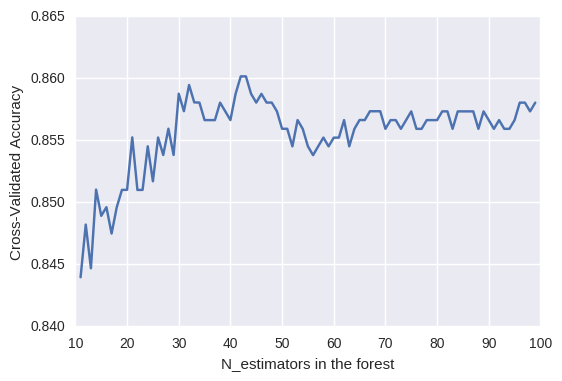

In [41]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_range[10:], scores[10:])
plt.xlabel('N_estimators in the forest')
plt.ylabel('Cross-Validated Accuracy')

#### 1.4.2 max_features

In [42]:
max_features = range(1,len(X.columns))
scores = list()

max_scores = -1
best_n = -1

for i in max_features:
    ml = RandomForestClassifier(max_features=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
# Best values
print(best_n, max_scores)

8 0.862999343579


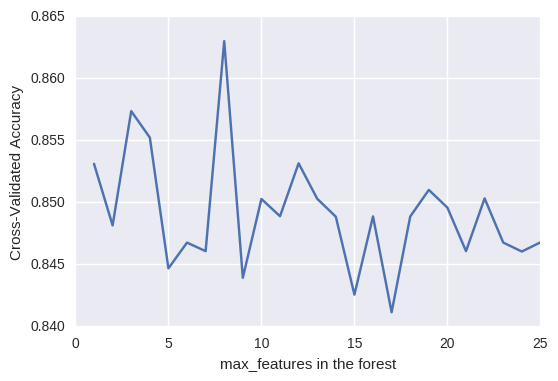

In [43]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, scores)
plt.xlabel('max_features in the forest')
plt.ylabel('Cross-Validated Accuracy')

We see that the best option here is 5, which is roughly the square root of the numbers of features.

#### 1.4.3 Model with ALL features

In [44]:
def RFCmodel_cv_featureImportance(X,y):
    """
        Compute the RandomForestClassifier for features dataframe X and classes features y.
        It prints the accuracy of the model using cross-validation and a graph displaying
        the importance for each features.
    """
    
    ml = RandomForestClassifier(n_estimators=51, max_features=5, random_state=1)

    # Cross-validation accuracy
    cross = (cross_val_score(ml, X, y, cv=10))
    print("Cross-validation:", cross.mean())

    # Feature importance
    ml.fit(X,y)
    feature_importance = ml.feature_importances_

    # Combining the features_importance array with the corresponding feature name
    l1 = list(zip(feature_importance, X.columns))
    l1.sort(key=lambda x: x[0], reverse=True)
    features = list(map(lambda x: x[0], l1))
    features_names = list(map(lambda x: x[1], l1))

    # Plot the features_importances graph
    graph = sns.barplot(features_names, features, palette='BuGn_r')
    graph.set_title("Features importance")
    graph.set_xticklabels(labels=features_names, rotation=90)
    plt.show()
    
    
    # Print confusion_matrix
    y_predicted = cross_val_predict(ml, X, y, cv=10)
    cm = metrics.confusion_matrix(y, y_predicted)
    print(cm)
    print("Confusion matrix")
    print("White as white: ", cm[0][0])
    print("White as black: ", cm[0][1])
    print("black as white: ", cm[1][0])
    print("black as black: ", cm[1][1])

Cross-validation: 0.855932046178


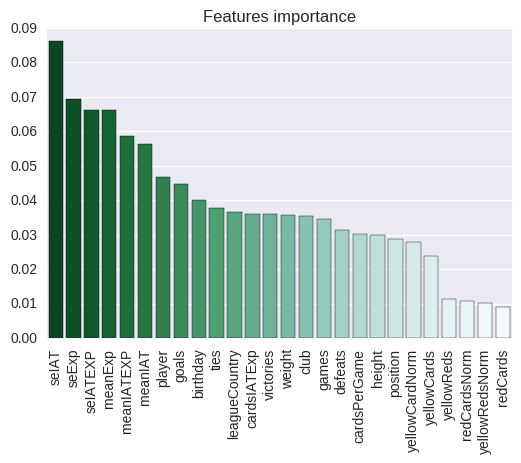

[[1156   33]
 [ 171   56]]
Confusion matrix
White as white:  1156
White as black:  33
black as white:  171
black as black:  56


In [45]:
RFCmodel_cv_featureImportance(X,y)

**BLA BLA BLA **

#### 1.4.4 Model with some selected features

Now we decided to run the model but with some arbitrarily-selected features.

In [46]:
list(data_player.columns)

['ties',
 'seExp',
 'redCards',
 'club',
 'height',
 'meanIAT',
 'meanExp',
 'seIAT',
 'yellowCards',
 'goals',
 'victories',
 'position',
 'games',
 'player',
 'leagueCountry',
 'yellowReds',
 'weight',
 'birthday',
 'defeats',
 'skinColor',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 'isBlack']

In [47]:
features_to_keep = [
    "leagueCountry",
    "club",
    "weight",
    "height",
    "games",
    "position",
    "birthday",
    'meanIATEXP',
    'seIATEXP',
    'cardsPerGame',
    'yellowCardNorm',
    'yellowRedsNorm',
    'redCardsNorm',
    'cardsIATExp',
]

X = data_player[features_to_keep]

Cross-validation: 0.858748876236


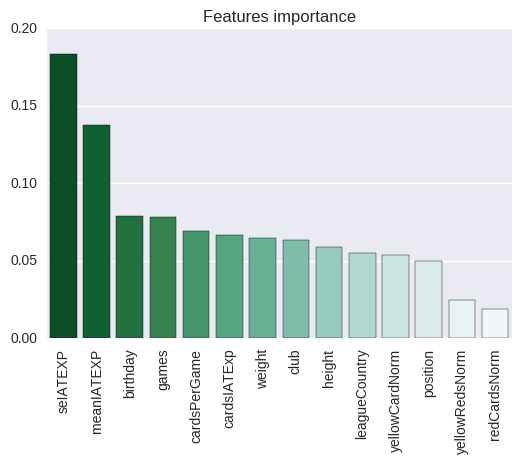

[[1165   24]
 [ 176   51]]
Confusion matrix
White as white:  1165
White as black:  24
black as white:  176
black as black:  51


In [48]:
RFCmodel_cv_featureImportance(X,y)

Cross-validation: 0.862270074347


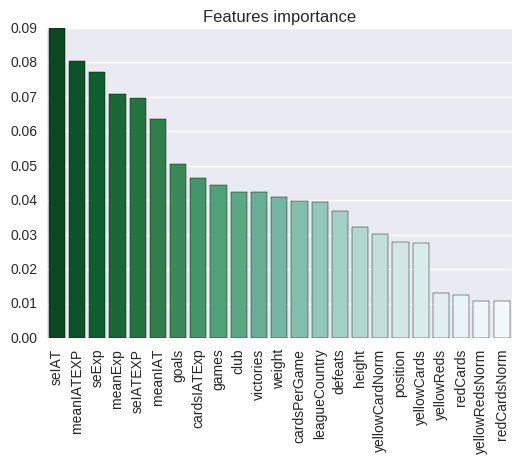

[[1158   31]
 [ 164   63]]
Confusion matrix
White as white:  1158
White as black:  31
black as white:  164
black as black:  63


In [49]:
features_experiment_1 = [
 'redCards',
 'victories',
 'height',
 'defeats',
 'seIAT',
 'weight',
 'meanExp',
 'seExp',
 'games',
 'club',
 'leagueCountry',
 #'birthday',
 'meanIAT',
 #'player',
 #'ties',
 'yellowReds',
 'goals',
 # 'skinColor',
 'position',
 'yellowCards',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 # 'isBlack',
]

X_experiment_1 = data_player[features_experiment_1]

RFCmodel_cv_featureImportance(X_experiment_1,y)

Experiment in selected features
1. drop player name, 0.8608 accuracy
2. drop birthday, 0.8615
3. drop ties, 0.8622

# 2.

>Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

### 2.3 Prepare data for ML

#### 2.3.1 Numerical values only

Our datasets has, at the moment, different types per column

In [50]:
data_player.dtypes

ties              float64
seExp             float64
redCards          float64
club              float64
height            float64
meanIAT           float64
meanExp           float64
seIAT             float64
yellowCards       float64
goals             float64
victories         float64
position          float64
games             float64
player            float64
leagueCountry     float64
yellowReds        float64
weight            float64
birthday          float64
defeats           float64
skinColor         float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
isBlack              bool
dtype: object

In [51]:
data_player.head()

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,...,defeats,skinColor,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp,isBlack
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,174.0,0.028156,0.0,33.0,182.0,0.527935,0.434369,0.030137,19.0,8.0,...,221.0,0.125,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000,0.048887,False
aaron-hunt,70.0,0.021812,1.0,85.0,183.0,0.567933,0.399713,0.024027,39.0,59.0,...,119.0,0.125,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909,0.144888,False
aaron-lennon,96.0,0.044180,0.0,78.0,165.0,0.537290,0.442548,0.039880,11.0,31.0,...,115.0,0.250,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000,0.028819,False
aaron-ramsey,42.0,0.061155,1.0,6.0,178.0,0.545806,0.461739,0.053753,31.0,39.0,...,67.0,0.000,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909,0.129311,False
abdelhamid-el-kaoutari,40.0,0.115304,2.0,48.0,180.0,0.404375,0.279791,0.163288,8.0,1.0,...,43.0,0.250,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818,0.190859,False


#### 2.3.3 Binary SkinColor

In order be able to make comparison between the classifier and the skinColor of a player, we need to have the skin information stored as a binary value.

We add a new column to our dataset: *blackSkin*. It will take value 0 if the skin is defined as *non-black* and value 1 otherwise.

In [52]:
data_player['blackSkin'] = -1
data_player['blackSkin'][data_player.skinColor>0.5] = 1
data_player['blackSkin'][data_player.skinColor<=0.5] = 0

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 2.4 Unsupervised learning

We have (arbitrarly) decided to work with the *k_means* algorithm from scikit.

Need to remove the two features about the skin color. As stated above, we will use the *blackSkin* feature to compute the percentage of dark and light skin colors in the clusters.

In [53]:
X = data_player.drop(['skinColor', 'blackSkin'], axis=1)
y = data_player.blackSkin

**Demonstration of the method used**

In will, compute which of the features is the best candidate to being removed. If the silhouette score by removing this feature is better than by keeping it, we drop the specific column and go through the loop one more time.

Below, we display a graph that shows the first iteration of the algorithm.

In [54]:
caca = X


scale = StandardScaler().fit(caca)
caca = scale.transform(caca)
caca = pd.DataFrame(caca, columns=X.columns)
caca

,ties,seExp,redCards,club,height,meanIAT,meanExp,seIAT,yellowCards,goals,...,birthday,defeats,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp,isBlack
0,3.567581,-0.287099,-0.746581,-0.411246,-0.024512,-0.335096,0.241257,-0.271660,-0.499568,-0.465300,...,-0.838902,3.718841,-0.078180,-0.280618,-1.320715,-0.499568,-0.690851,-0.746581,-0.742052,-0.436940
1,0.429076,-0.406734,0.014512,1.586962,0.122558,0.026529,-0.145221,-0.388805,0.310264,0.764420,...,-1.286372,1.152783,-0.051114,-0.398942,-0.258475,0.310264,-0.690851,0.014512,-0.150509,-0.436940
2,1.213702,0.015078,-0.746581,1.317972,-2.524687,-0.250512,0.332461,-0.084826,-0.823501,0.089280,...,0.042228,1.052153,0.010662,-0.034672,-1.357157,-0.823501,-0.690851,-0.746581,-0.865709,-0.436940
3,-0.415906,0.335183,0.014512,-1.448776,-0.612788,-0.173517,0.546481,0.181181,-0.013669,0.282177,...,1.243769,-0.155404,0.151053,0.260109,-0.206177,-0.013669,-0.690851,0.014512,-0.246495,-0.436940
4,-0.476261,1.356285,0.775606,0.165160,-0.318650,-1.452211,-1.482555,2.281503,-0.944976,-0.634085,...,0.141666,-0.759182,-1.487459,1.854568,-0.362910,-0.944976,2.211953,0.775606,0.132758,-0.436940
5,-0.989286,0.691829,-0.746581,-0.334391,-0.318650,-1.322774,-1.519162,1.025788,-0.823501,-0.585861,...,0.122331,-1.035914,-1.431552,0.865393,-0.192587,-0.823501,0.034850,-0.746581,-0.738806,2.288643
6,-1.472133,-0.392999,-0.746581,1.202691,1.004972,-0.476551,-0.542864,-0.323497,-1.268909,-0.658197,...,1.611137,-1.664850,-0.513723,-0.357834,-1.666075,-1.268909,-0.690851,-0.746581,-1.043286,2.288643
7,-1.653201,-0.098598,-0.746581,-0.334391,0.857903,0.522716,-0.540238,0.046347,-1.268909,-0.658197,...,0.423407,-1.790637,0.047482,-0.023879,-1.666075,-1.268909,-0.690851,-0.746581,-1.043286,2.288643
8,-0.928930,-0.524754,0.775606,1.125837,-0.318650,-0.056499,-0.377425,-0.486689,-0.418585,-0.585861,...,0.486937,-0.281191,-0.203149,-0.506028,0.546204,-0.418585,-0.690851,0.775606,-0.193641,2.288643
9,-1.441955,-0.409887,0.014512,1.087410,-0.465719,-0.583387,-1.188435,-0.464057,-1.147434,-0.658197,...,-1.523918,-1.212016,-0.866915,-0.438120,-0.742689,-1.147434,-0.690851,0.014512,-0.777491,2.288643


In [55]:
silhouettes = list()

for col in caca.columns:
    data_without_col = caca.drop(col, axis=1)
    
    kmeans = KMeans(n_clusters=2).fit(data_without_col)
    silhouette = sklearn.metrics.silhouette_score(data_without_col, kmeans.labels_)
    
    silhouettes.append(silhouette)
    
    #skin_sep = (kmeans.labels_ == y).sum() / len(y)
    #skin_separations.append(max(skin_sep, 1-skin_sep))

In [56]:
# Add columns names to columns silhouette value and order
l1 = list(zip(silhouettes, X.columns))
l1.sort(key=lambda x: x[0], reverse=True)

sil_values = list(map(lambda x: x[0], l1))
sil_names = list(map(lambda x: x[1], l1))

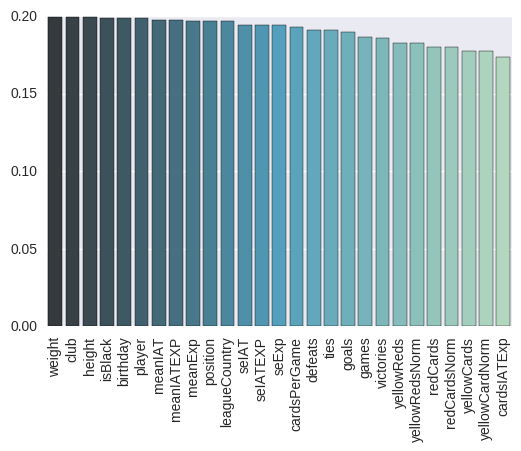

In [57]:
# Plot graph
graph = sns.barplot(sil_names, sil_values, palette='GnBu_d')
graph.set_xticklabels(labels=sil_names, rotation=90)
plt.show()

So here,the leagueCountry feature needs to be remove

NOW, LOOP !

In [58]:
new_data = caca
kmeans = KMeans(n_clusters=2).fit(caca)
data_silhouette = sklearn.metrics.silhouette_score(caca, kmeans.labels_)
        
print("TOUT", data_silhouette)

to_del = "nope"
to_del_min = -1

while True:
    for col in new_data.columns:
        data_without_col = new_data.drop(col, axis=1)

        kmeans = KMeans(n_clusters=2).fit(data_without_col)
        silhouette = sklearn.metrics.silhouette_score\
                        (data_without_col, kmeans.labels_)

        if silhouette > to_del_min:
            to_del = col
            to_del_min = silhouette

        #skin_sep = (kmeans.labels_ == y).sum() / len(y)
        #skin_separations.append(max(skin_sep, 1-skin_sep))
    if to_del_min > data_silhouette:
        new_data = new_data.drop(to_del, axis=1)
        data_silhouette = to_del_min
        print(to_del, "DELETED")

    else:
        break

TOUT 0.190766641193
weight DELETED
club DELETED
birthday DELETED
height DELETED
isBlack DELETED
player DELETED
position DELETED
meanIAT DELETED
leagueCountry DELETED
meanExp DELETED
meanIATEXP DELETED
defeats DELETED
ties DELETED
games DELETED
cardsPerGame DELETED
goals DELETED
victories DELETED
yellowReds DELETED
yellowRedsNorm DELETED
yellowCardNorm DELETED
yellowCards DELETED
cardsIATExp DELETED
redCards DELETED
redCardsNorm DELETED
seExp DELETED
seIATEXP DELETED


ValueError: Found array with 0 feature(s) (shape=(1416, 0)) while a minimum of 1 is required.